#### Support Vector Machines Exercise using recepies and associated reviews

In [12]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Now it's time for another guided example. This time we're going to look at recipes. Specifically we'll use the epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

What we want to see is if we can use the ingredient and keyword list to predict the rating. For someone writing a cookbook this could be really useful information that could help them choose which recipes to include because they're more likely to be enjoyed and therefore make the book more likely to be successful.

First let's load the dataset. It's [available on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes). We'll use the csv file here and as pull out column names and some summary statistics for ratings.

In [3]:
raw_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')

In [4]:
# huge number of columns
raw_data.shape

(20052, 680)

In [5]:
raw_data.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# the title is the only non-numeric feature
raw_data.dtypes[raw_data.dtypes == 'object']

title    object
dtype: object

In [4]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

We learn a few things from this analysis. From a ratings perspective, there are just over 20,000 recipes with an average rating of 3.71. What is interesting is that the 25th percentile is actually above the mean. This means there is likely some kind of outlier population. This makes sense when we think about reviews: some bad recipes may have very few very low reviews.

Let's validate the idea a bit further with a histogram.

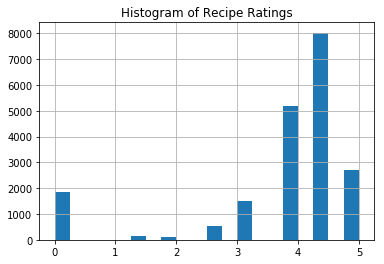

In [5]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

So a few things are shown in this histogram. Firstly there are sharp discontinutities. We don't have continuous data. No recipe has a 3.5 rating, for example. Also we see the anticipated increase at 0.

Let's try a naive approach again, this time using SVM Regressor. But first, we'll have to do a bit of data cleaning.

In [7]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

What we can see right away is that nutrition information is not available for all goods. Now this would be an interesting data point, but let's focus on ingredients and keywords right now. So we'll actually drop the whole columns for calories, protein, fat, and sodium. We'll come back to nutrition information later.

In [8]:
# drop rating because that is the target
# drop title because that is a category

from sklearn.svm import SVR

svr = SVR()
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.3, replace=True, random_state=1)
Y = raw_data.rating.sample(frac=0.3, replace=True, random_state=1)
svr.fit(X,Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

__Note that this actually takes quite a while to run, compared to some of the models we've done before. Be patient.__ It's because of the number of features we have.

Let's see what a scatter plot looks like, comparing actuals to predicted.

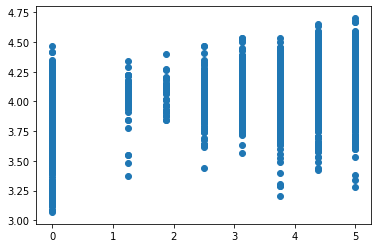

In [9]:
plt.scatter(Y, svr.predict(X))

Now that is a pretty useless visualization. This is because of the discontinuous nature of our outcome variable. There's too much data for us to really see what's going on here. If you wanted to look at it you could create histograms, here we'll move on to the scores of both our full fit model and with cross validation. Again if you choose to run it again it will take some time, so you probably shouldn't.

In [10]:
svr.score(X, Y)

-0.003978314483867651

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(svr, X, Y, cv=5)

array([-0.01787926, -0.02916288, -0.02841122, -0.03767394, -0.01735362])

Oh dear, so this did seem not to work very well. In fact it is remarkably poor. Now there are many things that we could do here. 

1. Firstly the overfit is a problem, even though it was poor in the first place. We could go back and clean up our feature set. There might be some gains to be made by getting rid of the noise.

1. We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

1. Lastly, we could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.

__And that is your challenge.__

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

Good luck!

When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews.

After all, people who eat chocolate _might_ just be happier people.

In [23]:
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)

In [24]:
X.shape

(20052, 674)

In [36]:
# change target variable to be binary
# 3.7 is the average

def binary_filler(x):
    if x > 3.7:
        return 1
    else:
        return 0

Y = raw_data.rating.apply(binary_filler)

In [37]:
Y.head()

0    0
1    1
2    1
3    1
4    0
Name: rating, dtype: int64

In [38]:
Y.shape

(20052,)

In [39]:
rfc = ensemble.RandomForestClassifier()

rfc.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [40]:
# examine how well the random forrest classifier performed
cross_val_score(rfc, X, Y, cv=5)

array([0.82099227, 0.81426078, 0.81770574, 0.81995012, 0.82094763])

In [28]:
# identify features that have performed the best
f_importances = pd.DataFrame(rfc.feature_importances_,
                            X.columns,
                            columns=['importance']).sort_values('importance', ascending=False)

In [44]:
f_importances.head(30)

,importance
bon appétit,0.015558
quick & easy,0.013930
gourmet,0.012291
summer,0.010807
vegetarian,0.009608
alcoholic,0.008692
milk/cream,0.008265
onion,0.008261
house & garden,0.008157
vegetable,0.007817


In [46]:
list(f_importances.head(30).index)

['bon appétit',
 'quick & easy',
 'gourmet',
 'summer',
 'vegetarian',
 'alcoholic',
 'milk/cream',
 'onion',
 'house & garden',
 'vegetable',
 'dairy',
 'kid-friendly',
 'winter',
 'bake',
 'egg',
 'wheat/gluten-free',
 'tomato',
 'spring',
 'healthy',
 'fall',
 'lemon',
 'herb',
 'side',
 'garlic',
 'cocktail party',
 'fruit',
 'vegan',
 'harpercollins',
 'kidney friendly',
 'no-cook']

### Evaluate performance using SVR on features identified above

In [47]:
# assign top 30 features

X = raw_data[list(f_importances.head(30).index)]

In [48]:
Y = raw_data.rating

In [49]:
# run model

from sklearn.svm import SVR
svr = SVR()

svr.fit(X,Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [50]:
cross_val_score(svr, X, Y, cv=5)

array([0.01509979, 0.0276625 , 0.04062875, 0.03051823, 0.03407361])

Support Vector Regression resulted in terrible results

### Evaluate performance using SVC with 2 categories(high/low)

In [47]:
# assign top 30 features

X = raw_data[list(f_importances.head(30).index)]

In [52]:
# change target variable to be binary
# 3.7 is the average

def binary_filler(x):
    if x > 3.7:
        return 1
    else:
        return 0

Y = raw_data.rating.apply(binary_filler)

In [53]:
Y.head()

0    0
1    1
2    1
3    1
4    0
Name: rating, dtype: int64

In [54]:
Y.shape

(20052,)

In [55]:
# run model

from sklearn.svm import SVC
svc = SVC()

svc.fit(X,Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [56]:
cross_val_score(svc, X, Y, cv=5)

array([0.79830466, 0.80129643, 0.80074813, 0.80349127, 0.80399002])

Much better result than the above, but still not great.

### Evaluate performance using SVC with 3 categories(high/mid/low)

In [47]:
# assign top 30 features

X = raw_data[list(f_importances.head(30).index)]

In [58]:
# change target variable to be binary
# 3.7 is the average

def binary_filler(x):
    if x > 4:
        return 'high'
    elif x > 3:
        return 'mid'
    else:
        return 'low'

Y = raw_data.rating.apply(binary_filler)

In [59]:
Y.head()

0     low
1    high
2     mid
3    high
4     mid
Name: rating, dtype: object

In [60]:
Y.shape

(20052,)

In [61]:
# run model

from sklearn.svm import SVC
svc = SVC()

svc.fit(X,Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [62]:
cross_val_score(svc, X, Y, cv=5)

array([0.5448654 , 0.54674645, 0.54699576, 0.55001247, 0.55001247])

Providing a more granular target variables reduced performance of the support vector classifier.

### Interpolate nan values from nutritional information and examine performance

In [74]:
# include top correlated features
X = raw_data[list(f_importances.head(25).index)]

In [77]:
# include nutritional features with
# correlated features
X = pd.concat((X, raw_data.iloc[:,2:6]), axis=1)

In [85]:
# find columns with null values
X.isna().sum()[X.isna().sum() > 0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

In [73]:
# identify nutrition columns to interpolate
# values for
list(raw_data.iloc[:,2:6].columns)

['calories', 'protein', 'fat', 'sodium']

In [86]:
for columns in list(raw_data.iloc[:,2:6].columns):
    X.loc[:, columns].interpolate(inplace=True)

In [88]:
# verify null values have been filled
X.isna().sum()[X.isna().sum() > 0]

Series([], dtype: int64)

In [89]:
# change target variable to be binary
# 3.7 is the average

def binary_filler(x):
    if x > 3.7:
        return 1
    else:
        return 0

Y = raw_data.rating.apply(binary_filler)

In [90]:
Y.head()

0    0
1    1
2    1
3    1
4    0
Name: rating, dtype: int64

In [91]:
# run model

from sklearn.svm import SVC
svc = SVC()

svc.fit(X,Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [92]:
cross_val_score(svc, X, Y, cv=5)

array([0.80877587, 0.80678135, 0.80473815, 0.80947631, 0.81122195])

Including nutritional value only slighly improved performance.

### Drop nan values from nutritional information and examine performance

In [97]:
# include top correlated features
X = raw_data[list(f_importances.head(25).index)]

In [98]:
# include nutritional features with
# correlated features
X = pd.concat((X, raw_data.iloc[:,2:6]), axis=1)

In [99]:
# verify size of full feature set
X.shape

(20052, 29)

In [100]:
X.dropna(inplace=True)

In [101]:
# verify that na values have been removed
X.shape

(15864, 29)

In [103]:
# change target variable to be binary
# 3.7 is the average

def binary_filler(x):
    if x > 3.7:
        return 1
    else:
        return 0

Y = raw_data.rating.apply(binary_filler)

In [104]:
Y.head()

0    0
1    1
2    1
3    1
4    0
Name: rating, dtype: int64

In [91]:
# run model

from sklearn.svm import SVC
svc = SVC()

cross_val_score(svc, X, Y, cv=5)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

array([0.80877587, 0.80678135, 0.80473815, 0.80947631, 0.81122195])

Including nutritional value only slighly improved performance.